# Marquardt Processing Sandbox

<img src="marquardt.png" />

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import xarray
import os.path as path
import datetime as dt
import warnings
import cosmicsense as cs
import glob
import os
import copy
import matplotlib.animation as animation
import wradlib
from scipy.optimize import minimize_scalar, minimize
import scipy.stats as stats
from scipy import spatial
from matplotlib.colors import rgb2hex
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
warnings.simplefilter('once', RuntimeWarning)

In [6]:
# Display figures inline
%matplotlib inline

# Retrieve and inspect metadata

In [7]:
attrs = pd.read_csv("marquardt_table.csv", sep=",")
attrs = attrs.set_index("id")
attrs["id"] = attrs.index
attrs.calstart = pd.to_datetime(attrs.calstart)
attrs.calend = pd.to_datetime(attrs.calend)
attrs

,institution,type,lon,lat,hasdata,hascal,calstart,calend,mincph,maxcph,calfact,id
id,,,,,,,,,,,,
1,UP,CRS 2000-B,12.958332,52.466406,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1400,3000,1.143399,1
2,UP,CRS 1000,12.956236,52.466162,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,500,1100,0.436303,2
4,UP,Lab-C,12.957875,52.467125,True,True,2019-05-28 09:45:00,2019-05-29 09:25:00,6500,11000,4.554603,4
9,UFZ,Styx Neutronica,12.957530,52.465357,False,True,2019-07-09 10:33:00,2019-07-10 13:08:00,-9999,-9999,NaN,9
11,UFZ,Styx Neutronica,12.959199,52.466456,False,False,1900-01-01 00:00:00,1900-01-01 00:00:00,-9999,-9999,NaN,11
12,UFZ,Styx Neutronica,12.958328,52.467479,False,True,2019-06-25 12:21:00,2019-06-26 16:19:00,-9999,-9999,NaN,12
13,UFZ,Styx Neutronica,12.959222,52.465763,False,True,2019-07-03 09:05:00,2019-07-04 13:27:00,-9999,-9999,NaN,13
21,GFZ,CRS 2000-B,12.957486,52.465838,True,False,1900-01-01 00:00:00,1900-01-01 00:00:00,1400,3000,1.143399,21
22,GFZ,CRS 2000-B,12.958571,52.465570,True,True,2019-05-22 08:00:00,2019-05-23 09:00:00,1400,3000,1.168573,22


In [8]:
#locs = pd.read_excel("/media/x/cosmicsense/data/fendt/theta_sheet_merged.xlsx", sheet_name="locations")
#locs = locs.set_index(locs.columns[0])

### Project geographic coordinates to UTM 32 N

In [9]:
wgs84 = wradlib.georef.epsg_to_osr(4326)
utm = wradlib.georef.epsg_to_osr(25833)

In [10]:
attrs["x"], attrs["y"] = wradlib.georef.reproject(attrs.lon, attrs.lat, projection_target=utm)
#locs["x"], locs["y"] = wradlib.georef.reproject(locs.lon_adjusted, locs.lat_adjusted, projection_target=utm)

### Retrieve and reproject auxiliary geodata

In [11]:
# ATB
atbdata, atblayer = wradlib.io.open_vector("/media/x/cosmicsense/data/marquardt/shapefiles/atb_gelaende_wgs84.shp")
atbborders, keys = wradlib.georef.get_vector_coordinates(atblayer, source_srs=wgs84, dest_srs=utm)
# Wublitz
wubldata, wubllayer = wradlib.io.open_vector("/media/x/cosmicsense/data/marquardt/shapefiles/wublitz.shp")
wublborders, keys = wradlib.georef.get_vector_coordinates(wubllayer, source_srs=wgs84, dest_srs=utm)
# buildings
builddata, buildlayer = wradlib.io.open_vector("/media/x/cosmicsense/data/marquardt/shapefiles/buildings.shp")
buildborders, keys = wradlib.georef.get_vector_coordinates(buildlayer, source_srs=wgs84, dest_srs=utm)
# roads
roaddata, roadlayer = wradlib.io.open_vector("/media/x/cosmicsense/data/marquardt/shapefiles/roads.shp")
roads, keys = wradlib.georef.get_vector_coordinates(roadlayer, source_srs=wgs84, dest_srs=utm)
# Land use
lutdata, lutlayer = wradlib.io.open_vector("/media/x/cosmicsense/data/marquardt/shapefiles/landuse.shp")
lut, lutkeys = wradlib.georef.get_vector_coordinates(lutlayer, source_srs=wgs84, dest_srs=utm)
# Forest
forestdata, forestlayer = wradlib.io.open_vector("/media/x/cosmicsense/data/marquardt/shapefiles/forest.shp")
forest, forestkeys = wradlib.georef.get_vector_coordinates(forestlayer, source_srs=wgs84, dest_srs=utm)

In [12]:
#bbox = atblayer.GetExtent()
bbox = 12.95370,12.96208, 52.46412, 52.4685
bboxxy = wradlib.georef.reproject([bbox[0], bbox[1]], [bbox[2], bbox[3]], projection_target=utm)

### Construct target grid

In [13]:
# Construct grid
delta = 10
xs = np.arange(bboxxy[0][0], bboxxy[0][1], delta)
ys = np.arange(bboxxy[1][0], bboxxy[1][1], delta)
xx, yy = np.meshgrid(xs, ys)
xxyy = np.array([xx.ravel(), yy.ravel()]).T
print("Grid shape:", xx.shape)

Grid shape: (48, 59)


In [14]:
from matplotlib.patches import Patch

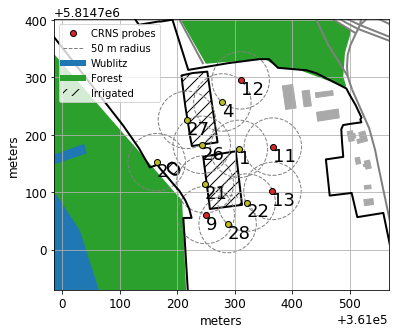

In [15]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect("equal")
#for locid in locs.index:
#    plt.plot(locs.loc[locid].x, locs.loc[locid].y, linewidth=0, marker="o", markersize=10, mfc="None", mec="tab:blue")

for id in attrs.index:
    if attrs.loc[id].hasdata:
        mfc = "tab:olive"
        mec = "black"
    else:
        mfc="tab:red"
        mec = "black"
    #matplotlib.patches.Circle(xy, radius=5, **kwargs)
    circle = plt.Circle((attrs.loc[id].x, attrs.loc[id].y), 50, ls="dashed", facecolor="None", edgecolor="grey")
    ax.add_artist(circle)
    plt.plot(attrs.loc[id].x, attrs.loc[id].y, linewidth=3, marker="o", markersize=6, mfc=mfc, mec=mec)
    plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), ha='left', va='top', color="black", fontsize=18)
wradlib.vis.add_lines(ax, atbborders, color='black', lw=2)
wradlib.vis.add_patches(ax, wublborders, color='tab:blue')
wradlib.vis.add_patches(ax, buildborders, color='darkgrey')
wradlib.vis.add_patches(ax, lut, lw=2, hatch="//", facecolors="None")
wradlib.vis.add_patches(ax, forest, lw=2, color="tab:green")
wradlib.vis.add_lines(ax, roads, color='grey', lw=2)

#plt.plot(xx, yy, linewidth=0, marker="o", ms=1, mfc="grey", mec="None")
#plt.plot(soilnetxy[:,0], soilnetxy[:,1], linewidth=0, marker="o", ms=6, mfc="None", mec="black")
#for i in range(len(lut)):
#    if lutkeys[i]=="forest":
#        wradlib.vis.add_patches(ax, lut[i], color='tab:green')
    
plt.xlim(bboxxy[0][0], bboxxy[0][1])
plt.ylim(bboxxy[1][0], bboxxy[1][1])
plt.grid()
ax.ticklabel_format(axis="y", useOffset=5814700)
ax.ticklabel_format(axis="x", useOffset=361000)
plt.xlabel("meters")
plt.ylabel("meters")

legend_elements = [plt.Line2D([0], [0], marker="o", ms=6,  mec="black", mfc="tab:red", lw=0, label="CRNS probes"),
                   plt.Line2D([0], [0], lw=1, ls="dashed", color="grey", label="50 m radius"),
                #plt.Line2D([0], [0], marker="o", ms=10,  mec="tab:blue", mfc="None", lw=0, label="Theta ground truth"),
                #plt.Line2D([0], [0], marker="o", ms=6,  mec="black", mfc="None", lw=0, label="SoilNet nodes"),
                plt.Line2D([0], [0], lw=6, color="tab:blue", label="Wublitz"),
                  plt.Line2D([0], [0], lw=6, color="tab:green", label="Forest"),
                  Patch(hatch="//", label="Irrigated", facecolor="None")]
_ = ax.legend(handles=legend_elements, loc="upper left", fontsize=10)

plt.savefig("overviewmap_mq.png", dpi=150, bbox_inches="tight")

### Collecting meteo data

From DWD at Potsdam:
- Pressure: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_03987_akt.zip
- Temperature & humidity: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/stundenwerte_TU_03987_akt.zip
- Precipitation: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/recent/stundenwerte_RR_03987_akt.zip

In [16]:
f_prec = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_RR_03987_akt.txt"
prec = pd.read_csv(f_prec, sep=";", na_values=-999)
prec.columns = ["station_id", "datetime", "quality", "depth", "ind", "wrtr", "eor"]
prec.datetime = pd.to_datetime(prec.datetime, format="%Y%m%d%H")
prec = prec.set_index("datetime")

In [17]:
f_press = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_P0_03987_akt.txt"
press = pd.read_csv(f_press, sep=";", na_values=-999)
press.columns = ["station_id", "datetime", "quality", "p", "p0", "eor"]
press.datetime = pd.to_datetime(press.datetime, format="%Y%m%d%H")
press = press.set_index("datetime")

In [18]:
f_temphum = "/media/x/cosmicsense/data/marquardt/dwd/stundenwerte_TU_03987_akt.txt"
temphum = pd.read_csv(f_temphum, sep=";", na_values=-999)
temphum.columns = ["station_id", "datetime", "quality", "temp2m", "relhum2m", "eor"]
temphum.datetime = pd.to_datetime(temphum.datetime, format="%Y%m%d%H")
temphum = temphum.set_index("datetime")
temphum["abshum2m"] = cs.conv.absolute_humidity(temphum.temp2m, temphum.relhum2m)

In [19]:
# Meteo station ATB Marquardt (from http://technologygarden.atb-potsdam.de/aqua_wetter.aspx)
meteoatbf = "/media/x/cosmicsense/data/marquardt/climate/atb_daily.csv"
meteoatb = pd.read_csv(meteoatbf, sep=";", na_values=-999)
meteoatb.date = pd.to_datetime(meteoatb.date, format="%d.%m.%Y %H:%M:%S")+dt.timedelta(days=1, seconds=-1)
meteoatb = meteoatb.set_index("date")

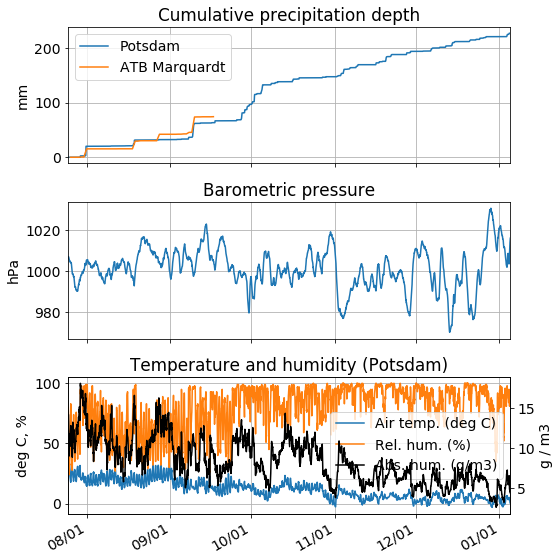

In [20]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex=True)
ax = ax.ravel()

start = "2019-07-25"
end = prec.index[-1].strftime("%Y-%m-%d")

plt.sca(ax[0])
plt.plot(prec[start:end].index, prec[start:end].depth.cumsum(), label="Potsdam")
plt.plot(meteoatb[start:end].index, meteoatb[start:end].Precipitation.cumsum(), label="ATB Marquardt")
#ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
plt.title("Cumulative precipitation depth")
plt.legend()
plt.ylabel("mm")
#xlim = ax.get_xlim()
#ax.set_xlim(dt.datetime.strptime(start, "%Y-%m-%d"), dt.datetime.strptime(end, "%Y-%m-%d"))

plt.sca(ax[1])
plt.plot(press["2019-05-06":].index, press["2019-05-06":].p0, label="Potsdam")
plt.grid()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.title("Barometric pressure")
plt.ylabel("hPa")

plt.sca(ax[2])
templ = plt.plot(temphum["2019-05-06":].index, temphum["2019-05-06":].temp2m, label="Air temp. (deg C)")
rehumpl = plt.plot(temphum["2019-05-06":].index, temphum["2019-05-06":].relhum2m, label="Rel. hum. (%)")
plt.grid()
plt.ylabel("deg C, %")
ax2 = ax[2].twinx()
abshumpl = plt.plot(temphum["2019-05-06":].index, temphum["2019-05-06":].abshum2m, color="black", label="Abs. hum. (g/m3)")
lns = templ+rehumpl+abshumpl
labs = [l.get_label() for l in lns]
ax[2].legend(lns, labs)
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.title("Temperature and humidity (Potsdam)")
plt.ylabel("g / m3")
plt.tight_layout()
#ax.set_xlim(xlim)
ax[2].set_xlim(dt.datetime.strptime(start, "%Y-%m-%d"), dt.datetime.strptime(end, "%Y-%m-%d"))

fig.autofmt_xdate()
plt.tight_layout()

Radar-based precipitation estimation on Aug 27, 2019, around Potsdam, shows massive spatial heterogeneity.

<img src="prec_20190827_mq.png">

## Read raw data

#### Quantify time offset for probe #28

Probe #28 exhibited a dramatic time offset of about four days between September 19 and October 9, 2019. In order to quantify and correct that offset, we compare the maintenance times (as recorded in the logbooks) with the first (1909150854.028) an last timestamps (1910010013.028) in the data files. The first timestamp after boot should be more helpful, because we expect that the first data log will appear twenty minutes later while for the last, we do not know how long after the last log the probe was switched off.

In [21]:
# nasty time shift
infile_on = pd.to_datetime("2019-09-15 08:54:04") # UTC
switch_on = pd.to_datetime("2019-09-19 10:00:00") # UTC
infile_off= pd.to_datetime("2019-10-05 13:33:00")# UTC
switch_off= pd.to_datetime("2019-10-09 14:44:00") # UTC
print(infile_on - switch_on, infile_off - switch_off)
time_shift_28 = infile_on - dt.timedelta(seconds=60*20) - switch_on
print(time_shift_28)

-5 days +22:54:04 -5 days +22:49:00
-5 days +22:34:04


Verify time shift by subtracting it from the first timestamp in the subsequent file in which we exxpect the timestamp not to be corrupted (1910051347.028).

In [22]:
pd.to_datetime("2019-10-05 13:47:24") - time_shift_28

Timestamp('2019-10-09 15:13:20')

#### Read sensor data

In [23]:
fpath = "/media/x/cosmicsense/data/marquardt/crns/"
crns = {}
for id in attrs.index:
    if not attrs.loc[id,"hasdata"]:
        continue
    df = pd.read_csv(path.join(fpath, "%d/%d_CRNS.txt" % (id, id)), sep="\t")
    df.datetime = pd.to_datetime(df.datetime)
    df = df.set_index("datetime")
    if id==28:
        df = df[:"2030-01-01"]
        # fix that nasty time shift
        index2 = df.index.to_pydatetime()
        changeix = (index2 >= infile_on) & (index2 <= infile_off)
        index2[changeix] = index2[changeix] - time_shift_28
        df = df.set_index(index2)
    if id==4:
        df["cph1"] = (df.counts1 + df.counts2) / cs.conv.s_to_h(df.nsecs1)
    else:
        df["cph1"] = df.counts1 / cs.conv.s_to_h(df.nsecs1)
        try:
            df["cph2"] = df.counts2 / cs.conv.s_to_h(df.nsecs2)
        except AttributeError:
            pass
    print(id, end=": ")
    print("%s to %s" % (df.index[0], df.index[-1]) )
    crns[id] = df

1: 2019-07-25 10:39:58 to 2020-01-06 10:27:00
2: 2019-07-31 12:37:38 to 2020-01-06 09:49:00
4: 2019-08-06 13:25:33 to 2020-01-06 10:43:00
21: 2019-07-25 00:17:00 to 2020-01-06 14:01:00
22: 2019-07-25 09:05:48 to 2020-01-06 10:57:00
26: 2019-08-23 10:20:31 to 2020-01-06 13:57:00
27: 2019-08-30 08:53:19 to 2020-01-06 13:54:00
28: 2019-09-12 09:55:02 to 2020-01-06 11:12:00


In [24]:
min_dtime = np.min([crns[key].index[0] for key in crns.keys()])
max_dtime = np.max([crns[key].index[-1] for key in crns.keys()])
print(min_dtime, "-", max_dtime)

2019-07-25 00:17:00 - 2020-01-06 14:01:00


### Compute average count rates from CRS-1000 and Lab-C tubes

For sensitivity calibration, we use the factors obtained during the `JFC #1` campaign in Fendt, plus the cross-calibration results for Marquardt. As of now, these factors are hard-coded in the `attrs` table.

However, for sensors `#26` and `#27`, we need to take some extra steps, since the `CRS 1000` tubes are "upgraded" with Lab-C tubes. The sensitivity of the Lab-C tubes will be calibrated using the "onboard" `CRS 1000` tubes.

In [25]:
ratiolabc1000_26 = crns[26].cph2.mean() / crns[26].cph1.mean()
ratiolabc1000_27 = crns[27].cph2[np.isfinite(crns[27].cph2)].mean() / crns[27].cph1.mean()
print(ratiolabc1000_26, ratiolabc1000_27)

4.5588440393410705 4.538252095812483


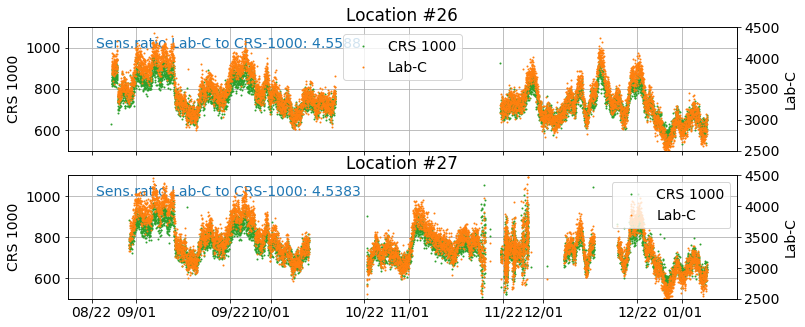

In [34]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,5), sharex=True, sharey=True)
ax = ax.ravel()

plt.sca(ax[0])
pl1000 = plt.plot(crns[26].index, crns[26].cph1, linestyle="None", marker=".", ms=2, color="tab:green", label="CRS 1000")
plt.ylabel("CRS 1000")
plt.ylim(500, 1100)
plt.title("Location #26")
plt.grid()
plt.text(dt.datetime(2019,8,23), 1000, "Sens.ratio Lab-C to CRS-1000: %.4f" % ratiolabc1000_26, color="tab:blue")

ax2 = ax[0].twinx()
plt.sca(ax2)
pllabc = plt.plot(crns[26].index, crns[26].cph2, linestyle="None", marker=".", ms=2, color="tab:orange", label="Lab-C")
plt.ylabel("Lab-C")
plt.ylim(2500, 4500)
lns = pl1000+pllabc
labs = [l.get_label() for l in lns]
plt.legend(lns, labs)

plt.sca(ax[1])
pl1000 = plt.plot(crns[27].index, crns[27].cph1, linestyle="None", marker=".", ms=2, color="tab:green", label="CRS 1000")
plt.ylabel("CRS 1000")
#plt.ylim(500, 1000)
plt.title("Location #27")
plt.grid()
plt.text(dt.datetime(2019,8,23), 1000, "Sens.ratio Lab-C to CRS-1000: %.4f" % ratiolabc1000_27, color="tab:blue")

ax2 = ax[1].twinx()
plt.sca(ax2)
pllabc = plt.plot(crns[27].index, crns[27].cph2, linestyle="None", marker=".", ms=2, color="tab:orange", label="Lab-C")
plt.ylabel("Lab-C")
plt.ylim(2500, 4500)
lns = pl1000+pllabc
labs = [l.get_label() for l in lns]
_ = plt.legend(lns, labs)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

In [27]:
crns[26].cph1 = (crns[26].counts2 / ratiolabc1000_26 + crns[26].counts1) / 2. / cs.conv.s_to_h(crns[26].nsecs1)
crns[27].cph1 = (crns[27].counts2 / ratiolabc1000_27 + crns[27].counts1) / 2. / cs.conv.s_to_h(crns[27].nsecs1)

## Filter spurious signals

Some probes are affected by spurious count rates. In order to keep useful parts of the signal, a pragmatic/heuristic filtering approach is applied which could be refined later:

1. Remove entirely unrealisticly count rates for specific probes (`mincph`, `maxcph`)
2. Remove count rates from spuriously short count intervals (`mininterv`)
3. After that, there are still spurious count rates.In order to detect these, we compute the maximum count rates over periods of six hours, and then apply a 24-hour-median filter to these 6-hour-maxima. That way, we try to truncate spurios peaks. In order to prevent too aggressive filtering, we add a `buffer` of the median count rates over a period of 24 hours.
4. We then interpolate this upper limit filter to the original timestamp values and use it to remove high values.
5. We remove unrealisticly low count rates (`mincph`), and than apply the same approach (points 3-4) to eliminate spuriously small values.  

In [28]:
buffer = 0.1
mininterv = 600

# Adjust min/max rates for #26 and #27

attrs.loc[26, "mincph"] = 400
attrs.loc[27, "mincph"] = 400
attrs.loc[26, "maxcph"] = 1100
attrs.loc[27, "maxcph"] = 1100

for i, key in enumerate(crns.keys()):
    x = crns[key].cph1.copy()
    x[x > attrs.loc[key, "maxcph"]] = np.nan
    x[x < attrs.loc[key, "mincph"]] = np.nan        
    x[crns[key].nsecs1 < mininterv] = np.nan
    median24 = x.resample("24H").median()
    # Maxfilter
    max6 = x.resample("6H").max()
    median24max6 = max6.resample("24H").median()
    maxfilter = np.array(median24max6 + buffer * median24)
    # Minfilter
    min6 = x.resample("6H").min()
    median24min6 = min6.resample("24H").median()
    minfilter = np.array(median24min6 - buffer * median24)    
    # Resample filter to original time stamps
    crns[key]["cph1_maxfilter"] = np.interp(x.index, median24.index, maxfilter)
    crns[key]["cph1_minfilter"] = np.interp(x.index, median24.index, minfilter)
    # Fill gaps
    crns[key]["cph1_maxfilter"] = crns[key].cph1_maxfilter.interpolate()
    crns[key]["cph1_minfilter"] = crns[key].cph1_minfilter.interpolate()
    # Apply filter
    crns[key]["cph1_filtered"] = x
    crns[key].loc[crns[key].cph1 > crns[key].cph1_maxfilter, "cph1_filtered"] = np.nan
    crns[key].loc[crns[key].cph1 < crns[key].cph1_minfilter, "cph1_filtered"] = np.nan

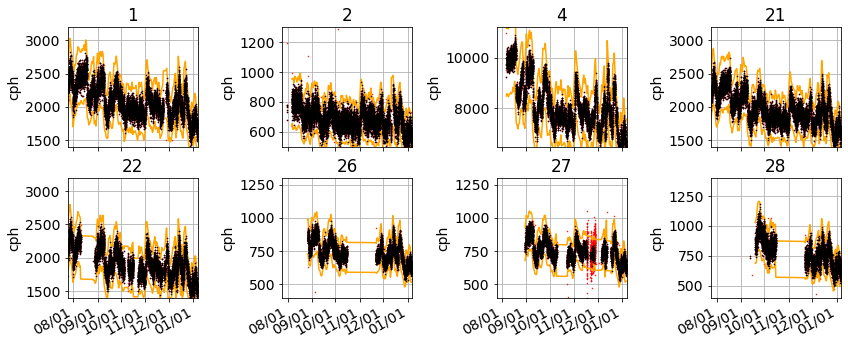

In [29]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,5), sharex=True)
ax = ax.ravel()

xlim = min_dtime, max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key].index, crns[key].cph1, linestyle="None", marker=".", ms=1, color="red")
    ax[i].plot(crns[key].index, crns[key].cph1_maxfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_minfilter, linestyle="-", ms=0, color="orange")
    ax[i].plot(crns[key].index, crns[key].cph1_filtered, linestyle="None", marker=".", ms=1, color="black")
    ax[i].set_title(key)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("cph")
    ax[i].set_xlim(xlim)
    if key==2:
        ax[i].set_ylim(250,2000)
    ax[i].set_ylim(attrs.loc[key,"mincph"], attrs.loc[key, "maxcph"]+200)
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[i].grid()
    #ax[i].legend()    

fig.autofmt_xdate()    
plt.tight_layout(h_pad=0.2)

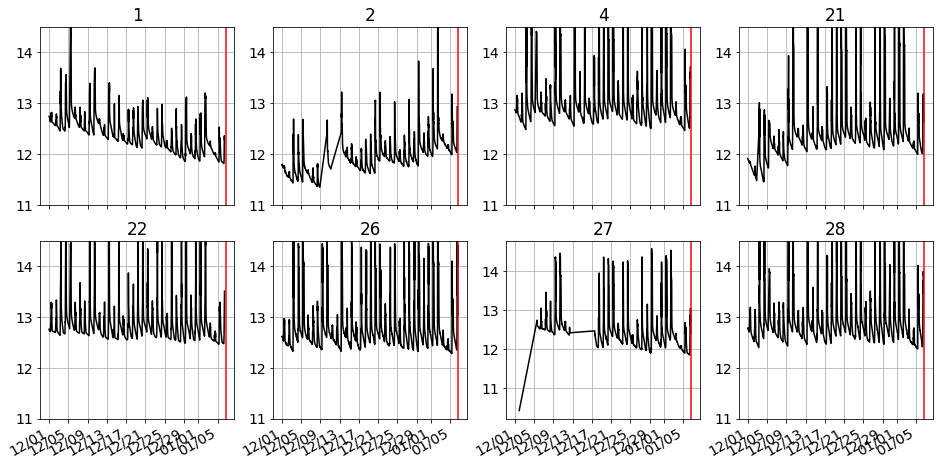

In [36]:
plt.rc('font', **{'size'   : 14})
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16,8), sharex=True)
ax = ax.ravel()

xlim = min_dtime, max_dtime

for i, key in enumerate(crns.keys()):
    ax[i].plot(crns[key]["2019-12-01":].index, crns[key]["2019-12-01":].volt, linestyle="-", ms=0, color="black")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[i].grid()
    ax[i].set_title(key)
    ax[i].axvline(dt.datetime.now(), color="red")
    if not key==27:
        ax[i].set_ylim(11,14.5)
fig.autofmt_xdate()    

#### Finally applying the sensitivity correction factors

In [28]:
for id in crns.keys():
    crns[id]["cph1cal"] = crns[id]["cph1_filtered"] / attrs.loc[id, "calfact"]

## Resample to uniform 20 minute interval

CRNS `#8` has a specific irrgularity: the sampling interval appears to be set to 10 minutes, but with frequent of length `1` inbetween. In order to fill these gaps, we decided to allow `nearest` to fill over `limit=2` while for the other CRNS, we only allow filling over `limit=1`.

In [29]:
dtrange = pd.date_range('2019-07-25 00:00:00', max_dtime, freq="20T")
crns20 = pd.DataFrame({}, index=dtrange)

for i, key in enumerate(crns.keys()):
    limit = 1
    if key==8:
        limit = 2
    crns20[key] = crns[key].cph1cal.resample('20T').nearest(limit=limit).reindex(dtrange)

## Correcting for variations in incoming neutron flux

#### NMBD station data

`nmdb.txt` contains reference (background) neutron count rates from [NMDB](http://www.nmdb.eu/nest/), for stations `KIEL2`, `JUNG`, `JUNG1`, and `DRBS` (Dourbes, Belgium). 

In [30]:
# NMDB data
nmdb = pd.read_csv("/media/x/cosmicsense/data/marquardt/nmdb/nmdb.txt", sep=";", comment="#", na_values="   null")
nmdb.datetime = pd.to_datetime(nmdb.datetime)
nmdb = nmdb.set_index("datetime")

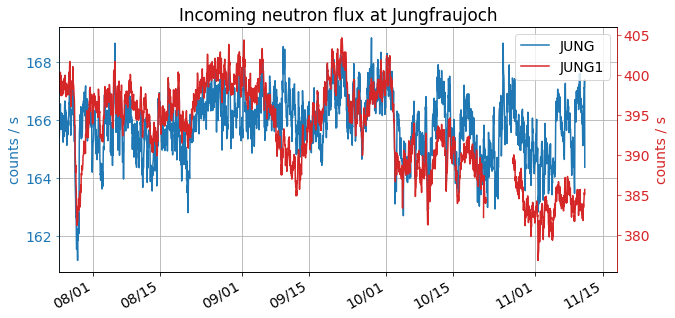

In [31]:
fig, ax1 = plt.subplots(figsize=(10, 5))
jungcol = "tab:blue"
jung = plt.plot(nmdb.index, nmdb.JUNG, color=jungcol)
plt.ylabel("counts / s", color=jungcol)
ax1.spines['left'].set_color(jungcol)
ax1.tick_params(axis='y', colors=jungcol)
ax1.grid()

ax2 = ax1.twinx()
jung1col = "tab:red"
jung1 = plt.plot(nmdb.index, nmdb.JUNG1, color="tab:red")
plt.ylabel("counts / s", color=jung1col)
ax2.spines['right'].set_color(jung1col)
ax2.tick_params(axis='y', colors=jung1col)

leg = plt.legend(jung+jung1, ["JUNG", "JUNG1"])
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.title("Incoming neutron flux at Jungfraujoch")

fig.autofmt_xdate() 

Several literature references (e.g. Zreda et al. 2012, Schroen et al. 2015, Andreasen et al. 2017) suggest to correct for variations in incoming neutron fluxes based on cosmic-ray neutron monitors available through http://www.nmdb.eu/nest. The idea is to compute a simple scaling factor $f_i$ based on measure neutron intensity $f_m$ and an arbitrary reference intensity $f_{ref}$ that depends on the actual neutron monitor.

\begin{equation*}
f_i = \frac{I_m}{I_{ref}}
\end{equation*}

In the dissertation thesis of Schroen (2016), a reference value $f_{ref}$ of 150 cps is suggested for the monitor on Jungfraujoch (JUNG).

In [32]:
fi = (nmdb.JUNG / nmdb.JUNG.mean())
fi.name="fi"
fi = fi.resample("1H").mean().resample("20T").ffill().reindex(dtrange)
fi2 = (nmdb.JUNG1 / nmdb.JUNG1.mean())
fi2.name="fi2"
fi2 = fi2.resample("1H").mean().resample("20T").ffill().reindex(dtrange)

## Correcting for variations in barometric pressure

Again based on Zreda et al. (2012), Andreasen et al. (2017) and many others, a correction factor $f_p$ is suggested in order to account for variations in barometric pressure.

\begin{equation*}
f_p = exp\Bigl(\frac{p_0 - p}{L}\Bigl)
\end{equation*}

Quoting from [Andreasen et al. (2017)](https://dl.sciencesocieties.org/publications/vzj/pdfs/16/8/vzj2017.04.0086):

> [...] $L$  is  the  mass  attenuation  length  for  high-energy  neutrons and is a function of cutoff rigidity
> (Desilets et al., 2006), $p$ is the barometric pressure at the time of measurement, and $P_0$ is an arbitrary
> reference pressure. Note that the units of $L$, $p$, and $p_0$ can be shielding depth (g/cm2) or pressure (Pa), 
> where $1 g/cm2 = 98.0665 Pa$. If shielding depth is used, $L$ ranges from 130 g/cm2 at high latitudes to 
> 144 g/cm2 at the equator (see Fig. 1).

[Zreda et al. (2012)](https://www.hydrol-earth-syst-sci.net/16/4079/2012/hess-16-4079-2012.pdf) complement that

> [... $p_0$] can be selected to be the long-term average pressure at the specific site, sea-level pressure, 
> or long-term averagepressure at a different reference site.

For $p_0$, we use $p_0 = 1013.25 mbar = 101325 Pa = 1033.23 g/cm²$ or the site average pressure, and $L=131.6$ for Germany (Fig. 1 in Andreasen et al. (2017).

In [33]:
p_0 = press.p0.mean()
L = 131.6 # g/cm2
fp = cs.core.corrfact_baro(press.p0, p_0, L)
fp = fp.resample("20T").ffill().reindex(dtrange)
fp.name="fp"

## Correcting for variations in atmospheric water vapor

In their overview, Andreasen et al. (2017) refer to Rosolem et al. (2013) when accounting for the effects of atmospheric water vapor:

\begin{equation*}
f_{wv} = 1 + 0.0054 * (h - h_{ref})
\end{equation*}

where $h$ is the absolute humidity of the air (in g/m3), and $h_{ref}$ is the absolute humidity at an arbitrary reference time.

The references do not elaborate on how to obtain the absolute humidity, but given the relative humidity and air temperature, we typically obtain $h$ by combining 

1. Relationship between vapor pressure $e$, saturated vapor pressure $e_s$ and relative humidity $rh$ (in %)

\begin{equation*}
e = e_s * rh / 100.
\end{equation*}

2. August-Roche-Magnus approximation of relation betweeen $e_s$ (mbar) and air temperature $T$ (in deg C) 

\begin{equation*}
e_s(T) = 6.1094 * exp\Bigl(\frac{17.625*T}{T + 243.04}\Bigl)
\end{equation*}

3. Universal law of perfect gases (with volume $V$, mass $m$, specific gas constant $R_S=461.4 J/kg/K$ for water vapor)

\begin{equation*}
e * V = m * R_s * T
\end{equation*}

In [34]:
fwv = cs.core.corrfact_vapor_rosolem(temphum.abshum2m)
fwv.name = "fwv"
fwv = fwv.resample("20T").ffill().reindex(dtrange)

## Combining the correction factors

We can now inspect the different correction factor, and use them to correct our neutron counts. According to Andreasen, this is done via

\begin{equation*}
N_{cor} = \frac{N*f_{wv}}{f_p*f_i}
\end{equation*}

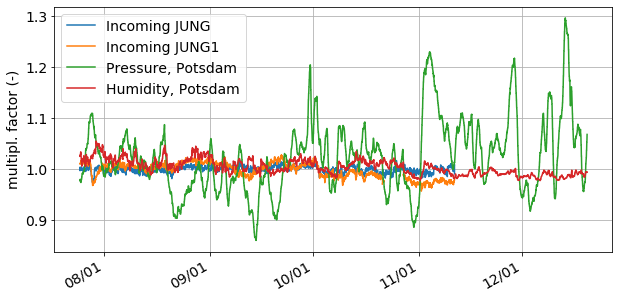

In [35]:
plt.rc('font', **{'size'   : 14})
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
plt.plot(fi.index, fi, label="Incoming JUNG")
plt.plot(fi2.index, fi2, label="Incoming JUNG1")
plt.plot(fp.index, fp, label="Pressure, Potsdam")
plt.plot(fwv.index, fwv, label="Humidity, Potsdam")
plt.ylabel("multipl. factor (-)")
#prec["2019-05-06":].depth.cumsum().plot()
plt.grid() 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.title("Correction factors")
plt.legend()#loc="lower left")
fig.autofmt_xdate() 

In [36]:
crns20c = crns20.copy()
for id in crns20c.keys():
    crns20c[id] = crns20c[id] * fwv / (fi * fp)

### Weighted spatial average of neutron intensity at 20 minute interval

In [37]:
# Each CRNS provides a weight on a common grid, based on distance and footprint characteristics
allw = np.zeros((np.sum(attrs.hasdata), len(xxyy)))
for i, id in enumerate(attrs.index[attrs.hasdata]):
    dist = cs.util.distance(np.array([attrs.loc[id,"x"], attrs.loc[id,"y"]]).T, xxyy)
    w = cs.core.horizontal_weight_koehli_approx(dist)# / (2 * np.pi * dist)
    #w = cs.core.horizontal_weight_zreda2008b(dist)
    w[dist>300] = 0
    allw[i] = w#normfunc(w)

In [38]:
arealcph = np.zeros((len(crns20c),len(xxyy)))
for i in range(len(arealcph)):
    tmp = np.array(crns20c.iloc[i]).reshape((-1,1))
    goodix = ~np.isnan(tmp).ravel()
    arealcph[i] = np.sum(tmp[goodix] * allw[goodix], axis=0) / allw[goodix].sum(axis=0)

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [39]:
crns20c["arealavg"] = np.nanmean(arealcph, axis=1)

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [40]:
arealavg24h_mean = crns20c["arealavg"].rolling("24H", min_periods=3*24-5).mean()
arealavg24h_std = crns20c["arealavg"].rolling("24H", min_periods=3*24-5).std()
arealavg24h_cov = 100 * arealavg24h_std / arealavg24h_mean

In [41]:
ids = np.array(attrs[attrs.hasdata].id)
singlecrns24h_mean = crns20c[ids].rolling("24H", min_periods=3*24-5).mean()
singlecrns24h_std = crns20c[ids].rolling("24H", min_periods=3*24-5).std()
singlecrns24h_cov = 100 * singlecrns24h_std / singlecrns24h_mean
singlecrns24h_cov_mean = singlecrns24h_cov.mean(axis=1)

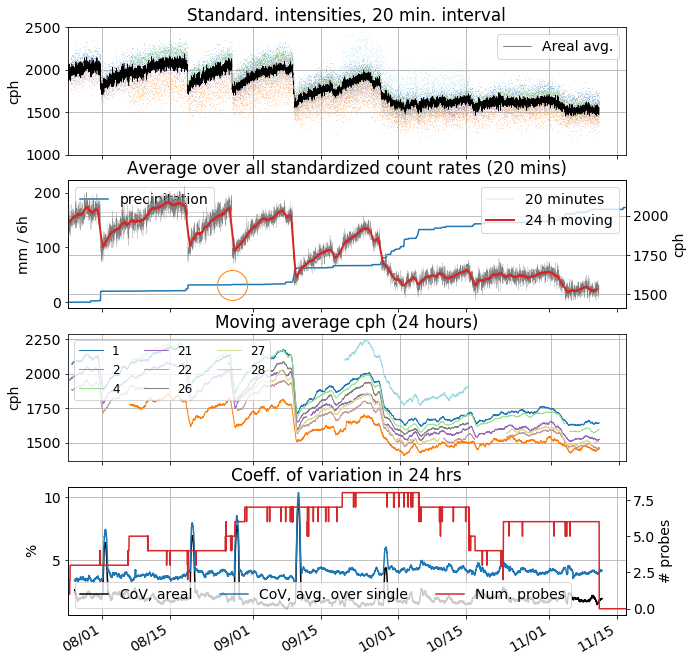

In [42]:
plt.rc('font', **{'size'   : 14})

colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=4, figsize=(10,12))

plt.sca(ax[0])
for i, id in enumerate(ids):
    plt.plot(crns20c.index, crns20c[id], color=colors[i], lw=0, marker=".", ms=1, mec="None")
#mpl = plt.plot(crns20c.index, crns20c[ids].mean(axis=1), color="black", label="Mean over all probes", lw=0.8)
mpl = plt.plot(crns20c.index, crns20c["arealavg"], color="black", label="Areal avg.", lw=0.5)
plt.grid()
plt.title("Standard. intensities, 20 min. interval")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.legend(mpl, ["Areal avg."])
plt.ylabel("cph")
plt.ylim(1000, 2500)

plt.sca(ax[1])
#tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
tmp = prec[start:end].depth.cumsum()#resample("6H", loffset=dt.timedelta(hours=3)).sum()
plt.plot(tmp.index, tmp, color="tab:blue", label="precipitation")
plt.plot(dt.datetime(2019,8,27,18), tmp["2019-08-27 18:00:00"], lw=0, marker="o",
         color="tab:orange", ms=30, mfc="None")
#plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
plt.legend(loc="upper left")
#plt.grid()
plt.ylabel("mm / 6h")

ax2 = ax[1].twinx()
plt.plot(crns20c.index, crns20c["arealavg"], lw=0.2, color="grey", label="20 minutes")
plt.plot(crns20c.index-dt.timedelta(hours=12), arealavg24h_mean, lw=2, color="tab:red", label="24 h moving")
plt.xlim(ax[0].get_xlim())
#ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
#plt.ylim(7600, 8600)
plt.grid()
plt.legend(loc="upper right")
plt.title("Average over all standardized count rates (20 mins)")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.ylabel("cph")

plt.sca(ax[2])
crns24hchst = crns20c.resample("24H").mean()
for i, id in enumerate(ids):
    tmp = crns20c[id].rolling("24H", min_periods=3*24-10).mean()
    plt.plot(tmp.index-dt.timedelta(hours=12), tmp, lw=1, color=colors[i], label=(str(id)))
    #plt.plot(crns24hchst.index+dt.timedelta(hours=12), crns24hchst[id], color=colors[i])
#plt.ylim(7600, 8800)
plt.grid()
plt.title("Moving average cph (24 hours)")
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.legend(ncol=3, loc="upper left", fontsize=12)
plt.ylabel("cph")

plt.sca(ax[3])
tmp = crns20c[ids].mean(axis=1).rolling("24H").std()
tmp2 = crns20c[ids].count(axis=1)#.rolling("24H").mean()
plareal = plt.plot(crns20c.index + dt.timedelta(hours=12), arealavg24h_cov, color="black")
plsingle = plt.plot(crns20c.index + dt.timedelta(hours=12), singlecrns24h_cov_mean, color="tab:blue")
plt.xlim(ax[0].get_xlim())
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.grid()
plt.title("Coeff. of variation in 24 hrs")
plt.ylabel("%")
ax4 = ax[3].twinx()
plnum = plt.plot(tmp2.index, tmp2, color="tab:red", label="# probes")
plt.ylabel("# probes")
plt.legend(plareal+plsingle+plnum, ["CoV, areal", "CoV, avg. over single", "Num. probes"], ncol=3)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))


fig.autofmt_xdate() 
#plt.tight_layout()

## Organize soil moisture campaign data

In [43]:
# cyls = pd.read_excel("/media/x/cosmicsense/data/fendt/theta_sheet_converted.xlsx", sheet_name="cylinder samples_lab results")
# fdr = pd.read_excel("/media/x/cosmicsense/data/fendt/theta_sheet_converted.xlsx", sheet_name="FDR-readings_converted")

In [44]:
# cyls.columns = ['location_id', 'depth_index', 'replicate', 'composite_id', 'depth', 
#                 'gross weight sample, fresh [g]', 'weight bag [g]', 'remarks', 
#                 'Number of sample (bags)', 'weight container', 'dry weight soil+container after 105°C',
#                 'freshweight', 'dry weight soil after 105°C', 'gravimetric water content (g/g soil (DW))',
#                 'theta', 'comment', 'bd', 'poro', 'wfps']

In [45]:
# fdr = fdr.iloc[:-3]
# fdr.columns = ['id', 'location_id', 'depth', 'fdr1',
#        'fdr2', 'fdr3', 'time', 'device', 'remarks', 'epsilon1',
#        'epsilon2', 'epsilon3', 'theta1', 'theta2', 'theta3', 'thetamean']
# fdr.location_id = fdr.location_id.astype(int)

### Relate CRNS locations to ground truth sampling locations

In [46]:
# # Find the closest CRNS location for each sampling location
# crnsxy = np.array([attrs.x, attrs.y]).T
# tree = spatial.KDTree(crnsxy)
# nextdist, nextix = tree.query(np.array([locs.x, locs.y]).T, k=1)
# locs["crnsid"] = attrs.index[nextix]

In [47]:
# # Assign a cylinder location ID to each CRNS in attribute table
# attrs["cylid"] = -9999
# for locid in np.unique(cyls["location_id"]):
#     attrs.loc[locs.loc[locid, "crnsid"], "cylid"] = locid
# # Assign cylinder stats to each CRNS in attribute table
# attrs["rhob"] = np.nan
# attrs["theta"] = np.nan

### Reorganise profile data

In [48]:
# thetaprofs = {}
# bdprofs = {}
# locs["type"] = ""
# for locid in locs.index:
#     if np.in1d(locid, cyls.location_id)[0]:
#         # cylinder profile
#         locs.loc[locid, "type"] = "cyl"
#         sortix = np.array(np.argsort(cyls.loc[cyls.location_id==locid, "depth"]))
#         deptharr = np.unique(np.array(cyls.loc[cyls.location_id==locid, "depth"])[sortix]).reshape((-1,1))
#         bdarr = np.array(cyls.loc[cyls.location_id==locid, "bd"])[sortix].reshape((-1,2))
#         thetaarr = np.array(cyls.loc[cyls.location_id==locid, "theta"])[sortix].reshape((-1,2))
#         bdprofs[locid] = np.hstack((deptharr, bdarr, bdarr.mean(axis=1).reshape((-1,1))))
#         thetaprofs[locid] = np.hstack((deptharr, thetaarr, thetaarr.mean(axis=1).reshape((-1,1))))
#     elif np.in1d(locid, fdr.location_id)[0]:
#         # ATTENTION: we discard the FDR profile at a cylinder location!
#         # FDR profile
#         locs.loc[locid, "type"] = "fdr"
#         sortix = np.array(np.argsort(fdr.loc[fdr.location_id==locid, "depth"]))
#         thetaarr = np.array(fdr.loc[fdr.location_id==locid, ["depth", "theta1", "theta2", "theta3", "thetamean"]])[sortix]
#         if not np.all(np.isnan(thetaarr[:,4])):
#             thetaprofs[locid] = thetaarr
#         else:
#             locs.loc[locid, "type"] = "invalid"
#     else:
#         # No match
#         locs.loc[locid, "type"] = "unknown"
#         print("WARNING: location %d is neither FDR nor cylinder profile." % locid)   

In [49]:
# fig, ax = plt.subplots(nrows=11, ncols=10, figsize=(11,10), sharex=True, sharey=True)
# ax = ax.ravel()
# for i, key in enumerate(thetaprofs.keys()):
#     try:
#         depth = thetaprofs[key][:,0]
#         if thetaprofs[key].shape[1] == 4:
#             ax[i].plot(thetaprofs[key][:,1:4], -depth)
#         else:
#             ax[i].plot(thetaprofs[key][:,1:3], -depth)
#         ax[i].plot(thetaprofs[key][:,-1], -depth, color="black", lw=2, ls="dashed")
#         ax[i].set_ylim(-30,0)
#         ax[i].set_xlim(0.2,0.8)
#         ax[i].grid()
#     except ValueError:
#         print(key)

#     if locs.loc[key, "type"] == "cyl":
#         txtcol = "tab:green"
#         txt = "CYL-%d" % key
#     elif locs.loc[key, "type"] == "fdr":
#         txtcol = "tab:blue"
#         txt = "FDR-%d" % key
#     else:
#         txtcol = "tab:red"
#         txt = "MISSING"
#     if np.all(np.isnan(thetaprofs[key][:,-1])):
#         txtcol = "tab:red"
       
#     ax[i].text(0.25, -10, txt, fontsize=10, color=txtcol)

### Retrieve mean profiles and fit standard shape functions to profiles

In [50]:
# def proffun1(depth, upper, lower, thresh):
#     """Standard bulk density profile shape in Fendt    
#     """
#     y = upper + ((lower - upper)/thresh) * depth
#     minbd = min(upper, lower)
#     maxbd = max(upper, lower)
#     y[y > maxbd] = maxbd
#     y[y < minbd] = minbd
#     return(y)    

In [51]:
# def proffun2(depth, upper, lower):
#     """Standard theta profile shape in Fendt    
#     """
#     y = upper + ((lower - upper)/30.) * depth
#     return(y) 

In [52]:
# def objfun(pars, proffun, obsprof, depths):
#     fitprof = proffun(depths, *pars)
#     return( np.sum((obsprof - fitprof)**2) )

In [53]:
# locs["theta0"] = np.nan
# locs["theta30"] = np.nan
# for i, locid in enumerate(thetaprofs.keys()):
#     ix = ~np.isnan(thetaprofs[locid][:,-1])
#     optres = minimize(fun=objfun, x0=np.array([0.4, 0.5]), args=(proffun2, thetaprofs[locid][ix,-1], thetaprofs[locid][ix,0]))["x"]    
#     locs.loc[locid, "theta0"] = optres[0]
#     locs.loc[locid, "theta30"] = optres[1]

In [54]:
# locs["bd0"] = np.nan
# locs["bd30"] = np.nan
# for i, locid in enumerate(bdprofs.keys()):
#     ix = ~np.isnan(bdprofs[locid][:,-1])
#     optres = minimize(fun=objfun, x0=np.array([1.0, 1.0]), args=(proffun2, bdprofs[locid][ix,-1], bdprofs[locid][ix,0]))["x"]    
#     locs.loc[locid, "bd0"] = optres[0]
#     locs.loc[locid, "bd30"] = optres[1]

In [55]:
# fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(9,6), sharex=True, sharey=True)
# ax = ax.ravel()
# plotdepths = np.arange(0,30,0.1)
# for i, locid in enumerate(locs.index[locs.type=="cyl"]):
#     ax[i].plot(thetaprofs[locid][:,-1], -thetaprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg. prof.")
#     #ax[i].plot(np.nanmean(cyltheta[id], axis=1), -obsdepths, lw=1, color="red", label="observed")
#     ax[i].plot(proffun2(plotdepths, *locs.loc[locid, ["theta0", "theta30"]].tolist()), -plotdepths, color="black", label="fitted")
#     #ax[i].set_title(str(id))
#     ax[i].text(.7,-5,str(locid), fontsize=12)
#     ax[i].grid()
#     if i==0:
#         ax[i].legend(loc="lower right", fontsize=8)
# title = fig.suptitle("Theta (m3/m3) profiles, observed and fitted", y=0.92, fontsize=14)
# #plt.tight_layout()

In [56]:
# fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(10,10), sharex=True, sharey=True)
# ax = ax.ravel()
# plotdepths = np.arange(0,30,0.1)
# for i, locid in enumerate(locs.index[locs.type=="fdr"][1:]):
#     ax[i].plot(thetaprofs[locid][:,-1], -thetaprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg. prof.")
#     #ax[i].plot(np.nanmean(cyltheta[id], axis=1), -obsdepths, lw=1, color="red", label="observed")
#     ax[i].plot(proffun2(plotdepths, *locs.loc[locid, ["theta0", "theta30"]].tolist()), -plotdepths, color="black", label="fitted")
#     #ax[i].set_title(str(id))
#     ax[i].text(.7,-5,str(locid), fontsize=12)
#     ax[i].grid()
#     #if i==0:
#     #    ax[i].legend(loc="lower right", fontsize=8)
# title = fig.suptitle("Theta from FDR (m3/m3) profiles, observed and fitted", y=0.92, fontsize=14)

In [57]:
# fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(9,6), sharex=True, sharey=True)
# ax = ax.ravel()
# plotdepths = np.arange(0,30,0.1)
# for i, locid in enumerate(locs.index[locs.type=="cyl"]):
#     ax[i].plot(bdprofs[locid][:,-1], -bdprofs[locid][:,0], lw=0, marker="o", mfc="None", color="black", label="avg. prof.")
#     #ax[i].plot(bd[id].mean(axis=1), -obsdepths, lw=1, color="red", label="observed")
#     ax[i].plot(proffun2(plotdepths, *locs.loc[locid, ["bd0", "bd30"]].tolist()), -plotdepths, color="black", label="fitted")
#     ax[i].text(1.2,-5,str(locid))
#     ax[i].grid()
#     if i==0:
#         ax[i].legend(loc="lower left", fontsize=8)
# title = fig.suptitle("Bulk density (g/cm3) profiles, observed and fitted", y=0.92, fontsize=14)

### Interpolation on a regular grid

In [58]:
# # Organize input arrays for gridding
# thetaix = ~np.isnan(locs.theta0)
# bdix = ~np.isnan(locs.bd0) #np.array(locs[~np.isnan(locs.bd0)][["x", "y"]])
# # Bulk density
# bdxy = np.array(locs[bdix][["x", "y"]])
# bdupper = np.array(locs[bdix].bd0)
# bdlower = np.array(locs[bdix].bd30)
# # Theta
# thetaxy = np.array(locs[thetaix][["x", "y"]])
# thetaupper = np.array(locs[thetaix].theta0)
# thetalower = np.array(locs[thetaix].theta30)

In [59]:
# # theta
# ok = wradlib.ipol.OrdinaryKriging(thetaxy, xxyy, cov='1.0 Exp(500.)', nnearest=10)
# ip_thetaupper = ok(thetaupper)
# ip_thetalower = ok(thetalower)
# # bd
# ok = wradlib.ipol.OrdinaryKriging(bdxy, xxyy, cov='1.0 Exp(500.)', nnearest=10)
# ip_bdupper = ok(bdupper)
# ip_bdlower = ok(bdlower)

In [60]:
# avgtheta_from_fit = proffun2(np.arange(0,30).reshape((-1,1)), ip_thetaupper, ip_thetalower).mean(axis=0)
# avgbd_from_fit = proffun2(np.arange(0,30).reshape((-1,1)), ip_bdupper, ip_bdlower).mean(axis=0)

In [61]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6), sharex=True, sharey=True)
# ax = ax.ravel()

# vmin=0.2
# vmax=1.6

# cmap = plt.cm.pink_r

# plt.sca(ax[0])
# ax[0].set_aspect("equal")
# p = plt.pcolormesh(xx, yy, ip_bdupper.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
# plt.colorbar(p, shrink=0.5)
# plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
# plt.title("Bulk density, upper")
# plt.grid()
# plt.xticks(rotation=30)

# plt.sca(ax[1])
# ax[1].set_aspect("equal")
# p = plt.pcolormesh(xx, yy, ip_bdlower.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
# plt.colorbar(p, shrink=0.5)
# plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
# plt.title("Bulk density, lower")
# plt.grid()
# plt.xticks(rotation=30)

# plt.sca(ax[2])
# ax[2].set_aspect("equal")
# p = plt.pcolormesh(xx, yy, avgbd_from_fit.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
# plt.colorbar(p, shrink=0.5)
# plt.plot(locs[~np.isnan(locs.bd0)].x, locs[~np.isnan(locs.bd0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
# plt.grid()
# plt.title("Bulk density, avg.")
# plt.xticks(rotation=30)
# plt.tight_layout()

In [62]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6), sharex=True, sharey=True)
# ax = ax.ravel()

# vmin=0.25
# vmax=0.8

# cmap = plt.cm.terrain_r

# plt.sca(ax[0])
# ax[0].set_aspect("equal")
# p = plt.pcolormesh(xx, yy, ip_thetaupper.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
# plt.colorbar(p, shrink=0.5)
# plt.plot(locs[~np.isnan(locs.theta0)].x, locs[~np.isnan(locs.theta0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
# plt.title("Theta, upper")
# plt.xticks(rotation=30)
# plt.grid()

# plt.sca(ax[1])
# ax[1].set_aspect("equal")
# p = plt.pcolormesh(xx, yy, ip_thetalower.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
# plt.colorbar(p, shrink=0.5)
# plt.plot(locs[~np.isnan(locs.theta0)].x, locs[~np.isnan(locs.theta0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
# plt.title("Theta, lower")
# plt.xticks(rotation=30)
# plt.grid()

# plt.sca(ax[2])
# ax[2].set_aspect("equal")
# p = plt.pcolormesh(xx, yy, avgtheta_from_fit.reshape(xx.shape), vmin=vmin, vmax=vmax, cmap=cmap)
# plt.colorbar(p, shrink=0.5)
# plt.plot(locs[~np.isnan(locs.theta0)].x, locs[~np.isnan(locs.theta0)].y, lw=0, marker="o", mec="tab:red", mfc="None")
# plt.grid()
# plt.title("Theta, profile mean, fit")
# plt.xticks(rotation=30)

# plt.tight_layout()

### Compute bulk density and average soil moisture per CRNS probe

1. Initial guess theta and bulk density in CRNS footprint
2. Compute vertical weights for each grid cell in the cutoff radius
3. Compute vertical weighted average for each profile
4. Compute horizontal weights for each grid cell in the cuttoff radius
4. Compute horizontally weighted average
5. Iterate until theta and bulk density become converge (typically within 3 steps)

In [63]:
# crnsxy = np.array([attrs.x, attrs.y]).T
# tree = spatial.KDTree(xxyy)
# ix = tree.query_ball_point(crnsxy, r=150)

#### Penetration depth and vertical weights

In [64]:
# # Initial guess of theta in the footprint
# attrs["thetaini"] = np.nan
# attrs["bdini"] = np.nan
# for i, id in enumerate(attrs.index):
#     attrs.loc[id, "thetaini"] = avgtheta_from_fit[ix[i]].mean()
#     attrs.loc[id, "bdini"] = avgbd_from_fit[ix[i]].mean()

In [65]:
# # Required input vars: pressure, abs. hum., vegetation height
# press_oncamp = press.p0["2019-06-25 09:00:00":"2019-06-26 17:00:00"].mean()
# h_oncamp = temphum["2019-06-25 09:00:00":"2019-06-26 17:00:00"].abshum2m.mean()
# Hveg = 0.
# depths = np.arange(0,30)

In [66]:
# maxiter = 5
# for i, id in enumerate(attrs.index):   
#     if not attrs.loc[id, "hasdata"]:
#         continue
#     print("Iterating for CRNS #%d..." % id)
#     # Initial guess
#     thetaguess = attrs.loc[id, "thetaini"]
#     bdguess = attrs.loc[id, "bdini"]
#     for iteri in range(maxiter):
#         print("\ttheta=%.3f, bd=%.2f" % (thetaguess, bdguess) )
#         # 3-d grid of theta and bulk density in cutoff radius
#         theta_vertgrd = proffun2(depths.reshape((-1,1)), ip_thetaupper[ix[i]], ip_thetalower[ix[i]])
#         bd_vertgrd = proffun2(depths.reshape((-1,1)), ip_bdupper[ix[i]], ip_bdlower[ix[i]])
#         # Distances of grid cells to probe
#         dists = cs.util.distance(crnsxy[i], xxyy[ix[i]])
#         # Vertical weights
#         vweights = cs.core.vertical_weight_koehli(dists, depths, thetaguess, press_oncamp, Hveg, bdguess)
#         theta_vertavgs = np.sum(vweights * theta_vertgrd, axis=0) / np.sum(vweights, axis=0)
#         bd_vertavgs = np.sum(vweights * bd_vertgrd, axis=0) / np.sum(vweights, axis=0 )
#         hweights = cs.core.horizontal_weight_koehli(dists, press_oncamp, Hveg, thetaguess, h_oncamp)
#         thetaguess = np.sum(hweights * theta_vertavgs) / np.sum(hweights)
#         bdguess = np.sum(hweights * bd_vertavgs) / np.sum(hweights)
        
#     attrs.loc[id, "theta"] = thetaguess
#     attrs.loc[id, "rhob"] = bdguess

### Calibrate N0 parameter

In [67]:
# Effective fraction
attrs["forestfrac"] = 0.
attrs.loc[2, "forestfrac"] = 0.3
# Biomass per m2, on top of grassland biomass, on forested fraction
attrs["biomass"] = 24.
biomasseffect = 0.9 # % per kg/ m2
# Apply correction
crns20c_vegc = crns20c.copy()
for id in attrs.index[attrs.hasdata]:
    crns20c_vegc[id] = crns20c_vegc[id] / (1 - attrs.loc[id, "biomass"] * attrs.loc[id, "forestfrac"] * 0.9 / 100.)

In [68]:
h24 = crns20c_vegc.rolling("24H", min_periods=int(3*24*0.8)).mean()

In [69]:
# def objtheta(n0, cph, dtimes, rhob, obstheta, porosity):
#     tmp = cs.core.n_to_theta_desilets(cph, n0, rhob=rhob)
#     x = np.nanmean(tmp[dtimes[0]:dtimes[1]])
#     error = np.abs(obstheta - x)
#     exc = tmp - porosity
#     exc[exc < 0] = 0
#     exc = exc[~np.isnan(exc)]
#     excerror = np.quantile(exc,0.9) + np.sum(tmp>1.)
#     totalerror = np.mean([excerror, error])
#     #print(n0, error, excerror, totalerror)
#     return totalerror

In [70]:
# caltimes = ["2019-06-25 08:00:00", "2019-06-26 18:00:00"]
# attrs["n0"] = np.nan
# for id in attrs.index[attrs.hasdata]:
#     #print(id)
#     cphin = h24[id].apply(copy.deepcopy)
#     rhob = attrs.loc[id, "rhob"] * 1000.
#     obstheta = attrs.loc[id, "theta"]
#     porosity = 1 - rhob / 2.65e3
#     optres = minimize_scalar(objtheta, args=(cphin, caltimes, rhob, obstheta, porosity))
#     #print(id, optres.fun, optres.x)
#     if not np.isnan(optres.fun):
#         attrs.loc[id,"n0"] = optres["x"]

In [71]:
crnstheta = h24.apply(copy.deepcopy)
for id in attrs.index[attrs.hasdata]:
    crnstheta[id] = cs.core.n_to_theta_desilets(h24[id].copy(), n0=2200, rhob=1200.)

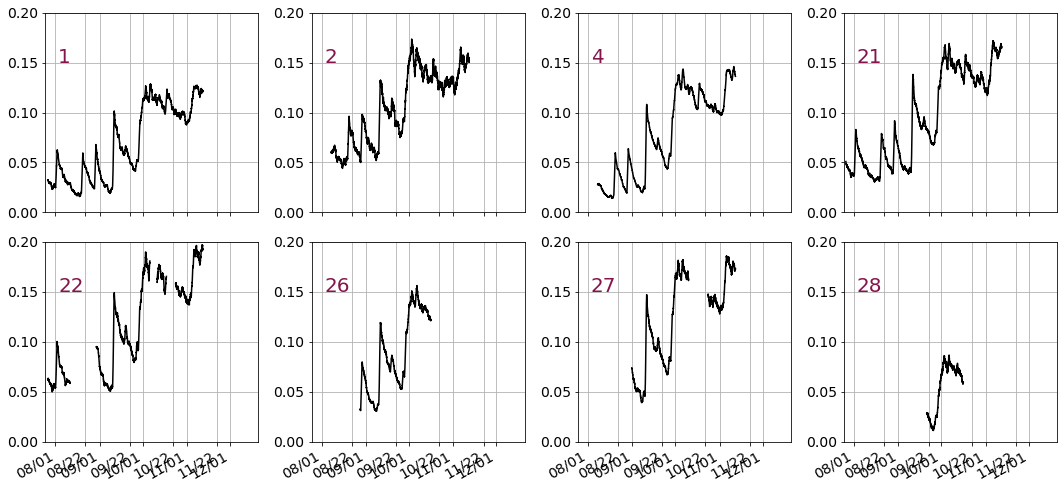

In [72]:
plt.rc('font', **{'size'   : 14})
ids = np.array(attrs[attrs.hasdata].id)
colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,7), sharex=True)
ax = ax.ravel()

for i, id in enumerate(attrs.index[attrs.hasdata]):
    plt.sca(ax[i])
    #if id==3:
    #    tmp=cs.core.n_to_theta_desilets(0.92*h24[id], n0=3400, rhob=attrs.loc[3, "bd_havg"]*1000)
    #    plt.plot(tmp.index+dt.timedelta(hours=12), tmp, color="black")
    #else:
    plt.plot(crnstheta.index+dt.timedelta(hours=12), crnstheta[id], color="black")
    ymin = 0.0
    ymax = 0.2
    #if crnstheta[id].max() > 0.75:
    #    ymax = 0.1 + 1-attrs.loc[id, "rhob"]/2.65# np.round(crnstheta[id].max(),1)
    #    ymin = np.round(crnstheta[id].min(),1)-0.05
    #    ax[i].spines['left'].set_color("#0074D9")
    #    ax[i].tick_params(axis='y', colors="#0074D9")
    plt.grid()
    plt.ylim(ymin, ymax)
    #plt.title("Theta (24 hours)")
    #plt.ylabel("m3/m3")
    #plt.plot(dt.datetime(2019,6,26,0,0,0), attrs.loc[id, "theta"], lw=0, marker="o", ms=8, mec="None", mfc="tab:red")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    plt.xlim(min_dtime-dt.timedelta(hours=1), max_dtime)
    #plt.axhline(y=1-attrs.loc[id, "rhob"]/2.65, linestyle="dashed", color="#0074D9")
    plt.text(dt.datetime(2019,8,3), 0.15, str(id), color="#85144b", fontsize=20)
    #plt.text(crnstheta.index[-1400], 0.8*ymax, "N0=%d" % int(attrs.loc[id, "n0"]), color="#85144b", fontsize=15)
    #if i==0:
    #    plt.text(dt.datetime(2019,5,3), 1-attrs.loc[id, "rhob"]/2.65 - 0.08, "porosity", color="#0074D9", fontsize=15)

fig.autofmt_xdate() 
plt.tight_layout()

<Figure size 1080x576 with 0 Axes>

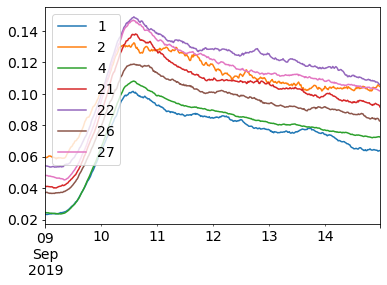

In [73]:
fig = plt.figure(figsize=(15,8))
crnstheta["2019-09-09":"2019-09-14"][[1,2,4,21,22,26,27]].plot(fig=fig)

In [74]:
# n0arr = np.array(attrs.n0[attrs.hasdata])
# n0ids = np.array(attrs.index[attrs.hasdata])
# forestcol = ["#784212"]
# edgecol = ["#145a32"]
# meadowcol = ["#28b463"]
# #turfcol = ["#1f618d"]
# legend_elements = [plt.Line2D([0], [0], color=forestcol[0], lw=6, label="forest"),
#                 plt.Line2D([0], [0], color=edgecol[0], lw=6, label="close to forest"),
#                 plt.Line2D([0], [0], color=meadowcol[0], lw=6, label="meadow")]
#                 #plt.Line2D([0], [0], color=turfcol[0], lw=6, label="peat")]
# n0_mean = attrs.loc[[5,17,8,24,2,16,3,4,18,25,23,7]].n0.mean()
# colors = forestcol*3 + edgecol*3 + meadowcol*12
# sortix = np.argsort(n0arr)
# fig, ax = plt.subplots(figsize=(7,7))
# xticks = np.arange(len(n0arr))
# plt.bar(xticks, n0arr[sortix], color=colors)
# plt.axhline(y=1.025*n0_mean, color="tab:red", ls="dashed", lw=2)
# plt.axhline(y=0.9725*n0_mean, color="tab:red", ls="dashed", lw=2)
# plt.text(1, 1.005*n0_mean, "avg. meadow N0 +/-2.5%", color="tab:red")
# plt.xticks(xticks)
# plt.xlabel("Cosmic Ray Neutron Sensor IDs")
# plt.ylabel("Calibrated N0 (counts per hour)")
# _ = ax.set_xticklabels(n0ids[sortix], rotation=45 )
# plt.grid()
# plt.ylim(2600,4000)
# #plt.title("Calibrated N0 - effect of vegetation?")
# _ = ax.legend(handles=legend_elements)

In [75]:
#attrs.loc[[5,17,8,24,2,16,3,4,18,25,23,7]].n0.mean()

## Construct gridded series of theta from calibrated CRNS

In [76]:
# Each CRNS provides a weight on a common grid, based on distance and footprint characteristics
allw = np.zeros((np.sum(attrs.hasdata), len(xxyy)))
for i, id in enumerate(attrs.index[attrs.hasdata]):
    dist = cs.util.distance(np.array([attrs.loc[id,"x"], attrs.loc[id,"y"]]).T, xxyy)
    w = cs.core.horizontal_weight_koehli_approx(dist)# / (2 * np.pi * dist)
    #w = cs.core.horizontal_weight_zreda2008b(dist)
    w[dist>100] = 0
    allw[i] = w

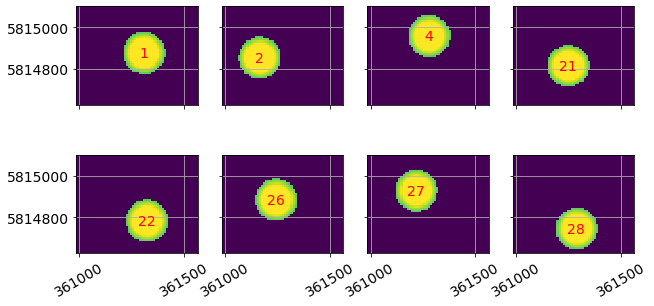

In [77]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(10,5),sharex=True, sharey=True)
ax=ax.ravel()
for i, id in enumerate(attrs.index[attrs.hasdata]):
    plt.sca(ax[i])
    ax[i].set_aspect('equal')
    p=plt.pcolormesh(xx, yy, allw[i].reshape(xx.shape), vmax=.5)
    plt.grid()
    plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
                               ha='center', va='center', color="red")
    plt.xticks(rotation=30)

In [78]:
startdate = "2019-07-25"
enddate = "2019-10-29"
sli = crnstheta[startdate:enddate][attrs.index[attrs.hasdata]].resample("12H").mean()
vals = np.zeros((len(sli),len(xxyy)))
for i in range(len(sli)):
    tmp = np.array(sli.iloc[i]).reshape((-1,1))
    goodix = ~np.isnan(tmp).ravel()
    vals[i] = np.sum(tmp[goodix] * allw[goodix], axis=0) / allw[goodix].sum(axis=0)

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [79]:
# fig = plt.figure(figsize=(15,7))
# gridspec.GridSpec(2,2)

# ax = []
# ax.append(plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=2))

# #plt.sca(ax[0])
# ax[0].set_aspect("equal")
# #quad1 = ax.imshow(vals[0].reshape(xx.shape), origin="lower", vmin=0.3, vmax=0.9, cmap=plt.cm.viridis_r)
# quad1 = ax[0].pcolormesh(xx, yy, vals[0].reshape(xx.shape), vmin=0.0, vmax=0.8, shading="flat", cmap=plt.cm.terrain_r)
# for id in attrs.index[attrs.hasdata]:
#     text_object = ax[0].annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), 
#                                ha='center', va='center', color="red")
# #for road in roadscoords:
# #    ax.plot(road[0], road[1], "grey", linestyle="dashed")
# #ax.plot(catchmcoords[0][0], catchmcoords[0][1], color="black")
# wradlib.vis.add_lines(ax[0], catborders, color='black', lw=2)
# wradlib.vis.add_lines(ax[0], roads, color='grey', ls="dashed", lw=2)
# ax[0].grid(color="white")
# tstamp = ax[0].set_title("")
# cb = plt.colorbar(quad1, shrink=0.75)
# cb.set_label("Theta (%)")
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())

# ax.append(plt.subplot2grid((2,2), (0,1), colspan=1, rowspan=1))
# #plt.plot(prec["2019-05-01":].index, prec["2019-05-01":].depth.cumsum(), "--", color="black")
# #plt.plot(meteo["2019-05-01":].index, meteo["2019-05-01":].precip.cumsum(), "--", color="blue")
# #tmp = meteo.precip.resample("6H", loffset=dt.timedelta(hours=3)).sum()
# tmpprec = prec[startdate:enddate].depth.resample("12H", loffset=dt.timedelta(hours=6)).sum()
# plt.plot(tmpprec.index, np.cumsum(tmpprec), label="Cumulative precipitation (mm)", color="black")
# precdot, = plt.plot(tmpprec.index[0], np.cumsum(tmpprec)[0], "ko")
# plt.legend(loc="upper left")
# plt.grid()
# plt.ylabel("mm")
# ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# ax.append(plt.subplot2grid((2,2), (1,1), colspan=1, rowspan=1))
# #plt.plot(prec["2019-05-01":].index, prec["2019-05-01":].depth.cumsum(), "--", color="black")
# #plt.plot(meteo["2019-05-01":].index, meteo["2019-05-01":].precip.cumsum(), "--", color="blue")
# #tmp = meteo.precip.resample("6H", loffset=dt.timedelta(hours=3)).sum()
# avgtheta = np.nanmean(vals, axis=1)
# avgtheta[np.sum(np.isnan(vals), axis=1) > 0.2*len(xxyy)] = np.nan

# plt.plot(sli.index, np.nanmean(vals, axis=1), label="< 20% cvrg.", color="grey", ls="dashed")
# plt.plot(sli.index, avgtheta, label="Avg. theta (%)", color="black")
# thetadot, = plt.plot(sli.index[0], np.nanmean(vals, axis=1)[0], "ko")
# plt.legend(loc="upper right")
# plt.grid()
# plt.ylabel("%")
# plt.xlim(ax[1].get_xlim())
# ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# fig.autofmt_xdate() 

# def init():
#     quad1.set_array([])
#     precdot.set_data([], [])
#     thetadot.set_data([], [])
#     return quad1, precdot, thetadot

# def animate(iter):
#     arr = vals[iter].reshape(xx.shape)[:-1, :-1]
#     quad1.set_array(arr.ravel())
#     precdot.set_data(tmpprec.index[iter], np.cumsum(tmpprec)[iter])
#     thetadot.set_data(sli.index[iter], avgtheta[iter])
#     #quad1.set_array(vals[iter].reshape(xx.shape))
#     tstamp.set_text(sli.index[iter].isoformat())
    
#     return quad1, precdot, thetadot


# anim = animation.FuncAnimation(fig,animate,frames=len(vals),interval=250,blit=False,repeat=False)
# tmp = anim.save('theta_animation.gif', writer='imagemagick')
# #plt.close()

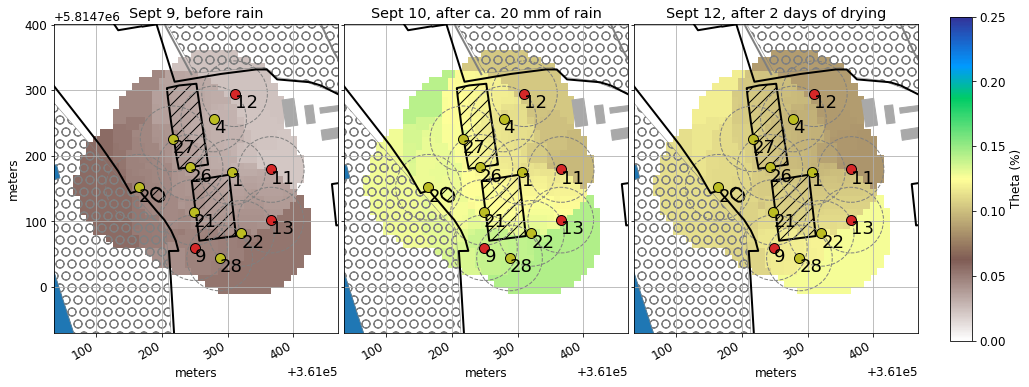

In [80]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,9), sharey=True)
#ax = ax.ravel()

beforedate = dt.datetime(2019,9,8,0,0)
duringdate = dt.datetime(2019,9,10,12,0)
afterdate = dt.datetime(2019,9,12,0,0)

#beforedate = dt.datetime(2019,9,1,0,0)
#duringdate = dt.datetime(2019,9,15,12,0)
#afterdate = dt.datetime(2019,10,1,0,0)

ixbefore = np.where(sli.index.to_pydatetime()==beforedate)[0][0]
ixduring = np.where(sli.index.to_pydatetime()==duringdate)[0][0]
ixafter = np.where(sli.index.to_pydatetime()==afterdate)[0][0]

vmin = 0
vmax = 0.25
xlim = bboxxy[0][0]+50, bboxxy[0][1]-100
ylim = bboxxy[1][0], bboxxy[1][1]

ax[0].set_aspect("equal")
plt.sca(ax[0])
axi=0
#quad1 = ax.imshow(vals[0].reshape(xx.shape), origin="lower", vmin=0.3, vmax=0.9, cmap=plt.cm.viridis_r)
quad1 = ax[axi].pcolormesh(xx, yy, vals[ixbefore].reshape(xx.shape), vmin=vmin, vmax=vmax, shading="flat", cmap=plt.cm.terrain_r)
for id in attrs.index:
    if attrs.loc[id].hasdata:
        mfc = "tab:olive"
        mec = "black"
    else:
        mfc="tab:red"
        mec = "black"
    #matplotlib.patches.Circle(xy, radius=5, **kwargs)
    circle = plt.Circle((attrs.loc[id].x, attrs.loc[id].y), 50, ls="dashed", facecolor="None", edgecolor="grey")
    ax[axi].add_artist(circle)
    plt.plot(attrs.loc[id].x, attrs.loc[id].y, linewidth=3, marker="o", markersize=10, mfc=mfc, mec=mec)
    plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), ha='left', va='top', color="black", fontsize=18)
wradlib.vis.add_lines(ax[axi], atbborders, color='black', lw=2)
wradlib.vis.add_patches(ax[axi], wublborders, color='tab:blue')
wradlib.vis.add_patches(ax[axi], buildborders, color='darkgrey')
wradlib.vis.add_patches(ax[axi], lut, lw=2, hatch="//", facecolors="None")
wradlib.vis.add_patches(ax[axi], forest, lw=0.5, hatch="O", facecolors="None", edgecolors="grey")
wradlib.vis.add_lines(ax[axi], roads, color='grey', lw=2)

plt.xlim(xlim)
plt.ylim(ylim)
plt.grid()
ax[axi].ticklabel_format(axis="y", useOffset=5814700)
ax[axi].ticklabel_format(axis="x", useOffset=361000)
plt.xlabel("meters")
plt.ylabel("meters")
plt.title("Sept 9, before rain")

#ax[axi].ticklabel_format(axis="y", useOffset=5298600)

axi = 1
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
#quad1 = ax.imshow(vals[0].reshape(xx.shape), origin="lower", vmin=0.3, vmax=0.9, cmap=plt.cm.viridis_r)
quad1 = ax[axi].pcolormesh(xx, yy, vals[ixduring].reshape(xx.shape), vmin=vmin, vmax=vmax, shading="flat", cmap=plt.cm.terrain_r)
for id in attrs.index:
    if attrs.loc[id].hasdata:
        mfc = "tab:olive"
        mec = "black"
    else:
        mfc="tab:red"
        mec = "black"
    #matplotlib.patches.Circle(xy, radius=5, **kwargs)
    circle = plt.Circle((attrs.loc[id].x, attrs.loc[id].y), 50, ls="dashed", facecolor="None", edgecolor="grey")
    ax[axi].add_artist(circle)
    plt.plot(attrs.loc[id].x, attrs.loc[id].y, linewidth=3, marker="o", markersize=10, mfc=mfc, mec=mec)
    plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), ha='left', va='top', color="black", fontsize=18)
wradlib.vis.add_lines(ax[axi], atbborders, color='black', lw=2)
wradlib.vis.add_patches(ax[axi], wublborders, color='tab:blue')
wradlib.vis.add_patches(ax[axi], buildborders, color='darkgrey')
wradlib.vis.add_patches(ax[axi], lut, lw=2, hatch="//", facecolors="None")
wradlib.vis.add_patches(ax[axi], forest, lw=0.5, hatch="O", facecolors="None", edgecolors="grey")
wradlib.vis.add_lines(ax[axi], roads, color='grey', lw=2)

plt.xlim(xlim)
plt.ylim(ylim)
plt.grid()
ax[axi].ticklabel_format(axis="y", useOffset=5814700)
ax[axi].ticklabel_format(axis="x", useOffset=361000)
plt.xlabel("meters")
#plt.ylabel("meters")
plt.title("Sept 10, after ca. 20 mm of rain")

axi = 2
ax[axi].set_aspect("equal")
plt.sca(ax[axi])
#quad1 = ax.imshow(vals[0].reshape(xx.shape), origin="lower", vmin=0.3, vmax=0.9, cmap=plt.cm.viridis_r)
quad1 = ax[axi].pcolormesh(xx, yy, vals[ixafter].reshape(xx.shape), vmin=vmin, vmax=vmax, shading="flat", cmap=plt.cm.terrain_r)
for id in attrs.index:
    if attrs.loc[id].hasdata:
        mfc = "tab:olive"
        mec = "black"
    else:
        mfc="tab:red"
        mec = "black"
    #matplotlib.patches.Circle(xy, radius=5, **kwargs)
    circle = plt.Circle((attrs.loc[id].x, attrs.loc[id].y), 50, ls="dashed", facecolor="None", edgecolor="grey")
    ax[axi].add_artist(circle)
    plt.plot(attrs.loc[id].x, attrs.loc[id].y, linewidth=3, marker="o", markersize=10, mfc=mfc, mec=mec)
    plt.annotate(str(id), xy=(attrs.loc[id,"x"], attrs.loc[id,"y"]), ha='left', va='top', color="black", fontsize=18)
wradlib.vis.add_lines(ax[axi], atbborders, color='black', lw=2)
wradlib.vis.add_patches(ax[axi], wublborders, color='tab:blue')
wradlib.vis.add_patches(ax[axi], buildborders, color='darkgrey')
wradlib.vis.add_patches(ax[axi], lut, lw=2, hatch="//", facecolors="None")
wradlib.vis.add_patches(ax[axi], forest, lw=0.5, hatch="O", facecolors="None", edgecolors="grey")
wradlib.vis.add_lines(ax[axi], roads, color='grey', lw=2)

plt.xlim(xlim)
plt.ylim(ylim)
plt.grid()
ax[axi].ticklabel_format(axis="y", useOffset=5814700)
ax[axi].ticklabel_format(axis="x", useOffset=361000)
plt.xlabel("meters")
#plt.ylabel("meters")
plt.title("Sept 12, after 2 days of drying")

fig.autofmt_xdate() 

fig.subplots_adjust(bottom=0.0, top=1., left=0.0, right=0.8,
                    wspace=0.02, hspace=0.02)

# add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

cb_ax = fig.add_axes([0.83, 0.25, 0.02, 0.5])
cbar = fig.colorbar(quad1, cax=cb_ax)
cbar.set_label("Theta (%)")

plt.savefig("mapsseries_mq.png", dpi=300, bbox_inches="tight")

In [81]:
avgtheta = np.nanmean(vals, axis=1)
avgtheta[np.sum(np.isnan(vals), axis=1) > 0.2*len(xxyy)] = np.nan

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice


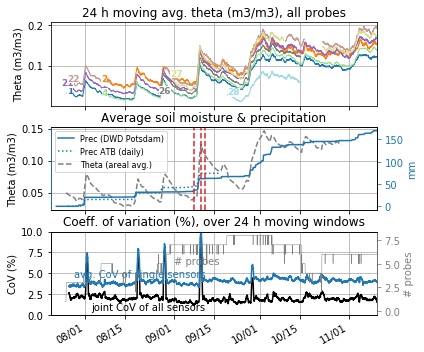

In [82]:
plt.rc('font', **{'size'   : 10})

colors = plt.cm.tab20(np.linspace(0,1,len(ids)))

fig, ax = plt.subplots(nrows=3, figsize=(6,5))

xlim = (dt.datetime(2019,7,20), dt.datetime(2019,11,11))

#plt.sca(ax[0])
#for i, id in enumerate(ids):
#    singlepl = plt.plot(crns20c.index, crns20c[id], color=colors[i], lw=0, marker=".", ms=1, mec="None")
##mpl = plt.plot(crns20c.index, crns20c[ids].mean(axis=1), color="black", label="Mean over all probes", lw=0.8)
#mpl = plt.plot(crns20c.index, crns20c["arealavg"], color="black", label="Areal avg.", lw=0.5)
#plt.grid()
#plt.title("Neutron intensity at 20 min. interval")
#ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
##plt.xlim(min_dtime-dt.timedelta(hours=1), None)
#plt.xlim(xlim)
#plt.legend(mpl+[plt.Line2D([0], [0], marker=".", color="grey", ms=3, lw=0)], ["Areal avg.", "Single probe cph"])
#plt.ylabel("counts per hour")
#plt.ylim(1000, 2500)
plstart = "2019-07-22"
plend = "2019-11-11"

plt.sca(ax[0])
for i, id in enumerate(ids):
    tmp = crnstheta[id]
    plt.plot(tmp.index-dt.timedelta(hours=12), tmp, lw=1, color=colors[i], label=(str(id)))
    if id in [21,]:
        #tmpix = np.where(~np.isnan(tmp))[0][-1]
        tmpix = np.where(~np.isnan(tmp))[0][0]
        shift = -dt.timedelta(hours=48)
    else:
        tmpix = np.where(~np.isnan(tmp))[0][0]
        shift = -dt.timedelta(hours=12)
    plt.text(tmp.index[tmpix]+shift, np.array(tmp)[tmpix], str(id), fontsize=9, weight="bold",
             color=colors[i], bbox=dict(facecolor="white", edgecolor='None', pad=0.0))#backgroundcolor="white", bbox=0)
    #plt.plot(crns24hchst.index+dt.timedelta(hours=12), crns24hchst[id], color=colors[i])
#plt.ylim(7600, 8800)
plt.grid()
plt.title("24 h moving avg. theta (m3/m3), all probes", fontsize=12)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
plt.xlim(xlim)
#plt.legend(ncol=2, loc="upper left", fontsize=12)
plt.ylabel("Theta (m3/m3)")

axi = 1
plt.sca(ax[axi])

lowcovpl = plt.plot(sli.index, np.nanmean(vals, axis=1), label="< 20% cvrg.", color="grey", ls="dashed")
plt.ylabel("Theta (m3/m3)")
plt.grid()

ax2 = ax[axi].twinx()

plprec = plt.plot(prec[plstart:plend].index, prec[plstart:plend].depth.cumsum())
plprecmq = plt.plot(meteoatb[plstart:plend].index, meteoatb[plstart:plend].Precipitation.cumsum(),
                   color="tab:blue", ls="dotted")
#tmp = prec.depth.resample("6H", loffset=dt.timedelta(hours=3)).sum()
#plprec = plt.bar(tmp.index, tmp, linewidth=0, width=0.2,  label="Precipitation (6 hrs)")
#plt.legend(loc="upper left")
#plt.grid()
ax2.set_ylabel("mm", color="tab:blue")
ax2.spines['left'].set_color("tab:blue")
ax2.tick_params(axis='y', colors="tab:blue")
plt.axvline(x=beforedate, color="tab:red", ls="dashed")
plt.axvline(x=duringdate, color="tab:red", ls="dashed")
plt.axvline(x=afterdate, color="tab:red", ls="dashed")

plt.xlim(xlim)
plt.legend(plprec+plprecmq+lowcovpl, ["Prec (DWD Potsdam)", "Prec ATB (daily)", "Theta (areal avg.)"], 
           loc="upper left", fontsize=8)
plt.title("Average soil moisture & precipitation", fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))



axi = 2
plt.sca(ax[axi])
tmp = crns20c[ids].mean(axis=1).rolling("24H").std()
tmp2 = crns20c[ids].count(axis=1)#.rolling("24H").mean()
plareal = plt.plot(crns20c.index + dt.timedelta(hours=12), arealavg24h_cov, color="black")
plsingle = plt.plot(crns20c.index + dt.timedelta(hours=12), singlecrns24h_cov_mean, color="tab:blue")
plt.xlim(ax[1].get_xlim())
ax[axi].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
#plt.xlim(min_dtime-dt.timedelta(hours=1), None)
plt.xlim(xlim)
plt.ylim(0,10)
plt.grid()
plt.title("Coeff. of variation (%), over 24 h moving windows", fontsize=12)
plt.ylabel("CoV (%)")
plt.text(dt.datetime(2019, 8, 3), 0.5, "joint CoV of all sensors")
plt.text(dt.datetime(2019, 7, 28), 4.5, "avg. CoV of single sensors", color="tab:blue")
ax4 = ax[axi].twinx()
plnum = plt.plot(tmp2.index, tmp2, color="grey", label="# probes", lw=0.5)
plt.ylabel("# probes", color="grey")
plt.text(dt.datetime(2019, 9,1), 5, "# probes", color="grey")
ax4.spines['right'].set_color("grey")
ax4.tick_params(axis='y', colors="grey")
#plt.legend(plareal+plsingle+plnum, ["joint CoV of all sensors", "average CoV of single sensors", "# probes"],
#           ncol=1)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

fig.autofmt_xdate() 

plt.tight_layout(h_pad=0.2)

plt.savefig("timeseries_mq.png", dpi=150, bbox_inches="tight")

### Export spatiotemporal data as netcdf using xarray

In [83]:
ds_theta = xarray.Dataset(data_vars={'theta': (('datetime', 'y', 'x'),
                                               vals.reshape((-1, xx.shape[0], xx.shape[1])))},
                          coords={'x': xs, 'y':ys, 'datetime': sli.index},
                          attrs={"epsg": "32632",
                                 "unit_theta":"m3/m3",
                                 "unit_coords":"meters",
                                 "tz":"UTC",
                                 "timeref":"end_of_interval",
                                 "starttime": sli.index[0].to_pydatetime().isoformat(),
                                 "endtime": sli.index[-1].to_pydatetime().isoformat()})

In [84]:
ds_theta.to_netcdf("/home/maik/b2drop/cosmicsense/inbox/marquardt/products/mc/theta_from_cph_grids.v0_1.nc",
                  encoding={"theta":{'zlib': True, 'complevel': 9}})

In [85]:
ds_theta.attrs

OrderedDict([('epsg', '32632'),
             ('unit_theta', 'm3/m3'),
             ('unit_coords', 'meters'),
             ('tz', 'UTC'),
             ('timeref', 'end_of_interval'),
             ('starttime', '2019-07-25T00:00:00'),
             ('endtime', '2019-10-29T12:00:00')])